### Imports

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Accessing Paper Titles

Unlabelled data

In [2]:
# Define the path to OAuth2 credentials JSON file
creds_path = r'C:\Users\cathe\practical-data-science-tutorial\src\data\credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Draft-dataset'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_names = ['Health and medical sciences', 'Social sciences', 'Business, economics and management']

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

papers_unlabelled = []

for specific_sheet_name in specific_sheet_names:
    # Open the Google Sheet
    sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

    # Get list of article names from the sheet
    papers = sheet.col_values(3)[1:]

    # Add all article names to a single list
    papers_unlabelled.extend(papers)

In [3]:
papers_unlabelled[:3]

['The psychological impact of quarantine and how to reduce it: rapid review of the evidence',
 'Global, regional, and national incidence, prevalence, and years lived with disability for 354 diseases and injuries for 195 countries and territories, 1990–2017: a systematic analysis for the Global Burden of Disease Study 2017',
 'A novel coronavirus outbreak of global health concern']

Labelled data

In [4]:
# Define the name of Google Sheet
google_sheet_name = 'Draft-dataset'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_name = 'Copy of finaldataset'

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

# Open the Google Sheet
sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

# Get list of article names & labels from the sheet
papers_labelled = sheet.col_values(3)[1:]
labels = sheet.col_values(15)[1:]

In [5]:
labels = [int(float(i)) for i in labels]

In [6]:
papers_labelled[:3], labels[:3]

(['COVID-19: the gendered impacts of the outbreak',
  'COVID-19: towards controlling of a pandemic',
  'Prevention and treatment of low back pain: evidence, challenges, and promising directions'],
 [3, 1, 3])

### Preprocessing

In [7]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Define stopwords to remove
stop_words = stopwords.words('english')
stop_words.extend(['covid19', 'sarscov2'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

# Map POS tags to WordNet tags for lemmatisation
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    else:
        return None

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Break down into individual words
    words = word_tokenize(title_lower)

    # Remove stopwords
    # words = [word for word in words if word not in stop_words]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Remove words that are nouns (NN, NNS, NNP, NNPS)
    non_noun_words = [word for word, pos in tagged_words if not pos.startswith('N')]

    # Lemmatisation of words & removal of words that aren't adjectives/verbs/adverbs
    lemmatised_words = [lemmatizer.lemmatize(word) for word in non_noun_words]

    return lemmatised_words

# Apply preprocessing to all titles
papers_labelled_processed = [preprocess_title(title) for title in papers_labelled]
papers_unlabelled_processed = [preprocess_title(title) for title in papers_unlabelled]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
papers_labelled_processed[:3]

[['covid19', 'the', 'gendered', 'of', 'the'],
 ['controlling', 'of', 'a', 'pandemic'],
 ['and', 'of', 'low', 'back', 'and', 'promising']]

In [9]:
papers_unlabelled_processed[:3]

[['the',
  'psychological',
  'of',
  'and',
  'how',
  'to',
  'reduce',
  'it',
  'rapid',
  'of',
  'the'],
 ['global',
  'regional',
  'and',
  'national',
  'and',
  'lived',
  'with',
  'for',
  '354',
  'and',
  'for',
  '195',
  'and',
  '19902017',
  'a',
  'systematic',
  'for',
  'the',
  'global',
  'of',
  '2017'],
 ['a', 'novel', 'of', 'global']]

### Bag of Words Representation

In [10]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer on preprocessed titles and transform them into a BoW representation
labelled_bow = vectorizer.fit_transform([" ".join(title) for title in papers_labelled_processed])

# Store the vocabulary used for creating BoW representations
vocabulary = vectorizer.get_feature_names_out()

In [11]:
labelled_bow

<100x288 sparse matrix of type '<class 'numpy.int64'>'
	with 623 stored elements in Compressed Sparse Row format>

In [12]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(vocabulary=vocabulary)

# Fit the vectorizer on preprocessed titles and transform them into a BoW representation
unlabelled_bow = vectorizer.fit_transform([" ".join(title) for title in papers_unlabelled_processed])

In [13]:
unlabelled_bow

<1242x288 sparse matrix of type '<class 'numpy.int64'>'
	with 5290 stored elements in Compressed Sparse Row format>

### Model Comparison

In [14]:
# Define the range of hyperparameters for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', None],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'], 
    'degree': [3, 4, 5] 
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

param_grid_dt = {
    'max_depth': [1, 2, 3, 5, 8, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5, 8]
}

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid_nn = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
    'alpha': [0.0001, 0.0005, 0.001],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# Initialize models
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=10000), param_grid_lr),
    'SVM': (SVC(random_state=42), param_grid_svm),
    'K-Nearest Neighbors': (KNeighborsClassifier(), param_grid_knn),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), param_grid_dt),
    'Multinomial Naive Bayes': (MultinomialNB(), param_grid_nb),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), param_grid_gb),
    'Neural Network': (MLPClassifier(random_state=42, max_iter=10000), param_grid_nn)
}

best_models = {}

for model_name, (model, param_grid) in models.items():
    # Perform grid search with 5-fold cross-validation using F1 score as the scoring metric
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')

    # Fit the model to find the best hyperparameters
    grid_search.fit(labelled_bow, labels)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Calculate F1 score using cross-validation
    cv_scores = cross_val_score(best_model, labelled_bow, labels, cv=5, scoring='f1_weighted')
    print(f"{model_name} with params {best_params} - Cross-Validation F1 score: {np.mean(cv_scores)}")

# Select the best model based on the mean cross-validation F1 score
best_model_name = max(best_models, key=lambda x: np.mean(cross_val_score(best_models[x], labelled_bow, labels, cv=5, scoring='f1_weighted')))
best_model = best_models[best_model_name]

print(f"The best model is: {best_model_name}")

Random Forest with params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} - Cross-Validation F1 score: 0.49515695415695404


c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_rati

Logistic Regression with params {'C': 1, 'penalty': 'l2', 'solver': 'sag'} - Cross-Validation F1 score: 0.43438905538905537
SVM with params {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'} - Cross-Validation F1 score: 0.46521109523431503
K-Nearest Neighbors with params {'n_neighbors': 9, 'weights': 'uniform'} - Cross-Validation F1 score: 0.34913793396146336
Decision Tree with params {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10} - Cross-Validation F1 score: 0.4866278753925813
Multinomial Naive Bayes with params {'alpha': 1.0, 'class_prior': None, 'fit_prior': True} - Cross-Validation F1 score: 0.40360420037478867


c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-package

Gradient Boosting with params {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200} - Cross-Validation F1 score: 0.5147668399114085
Neural Network with params {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'solver': 'sgd'} - Cross-Validation F1 score: 0.48068129256364556
The best model is: Gradient Boosting


In [14]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn_evaluation import plot

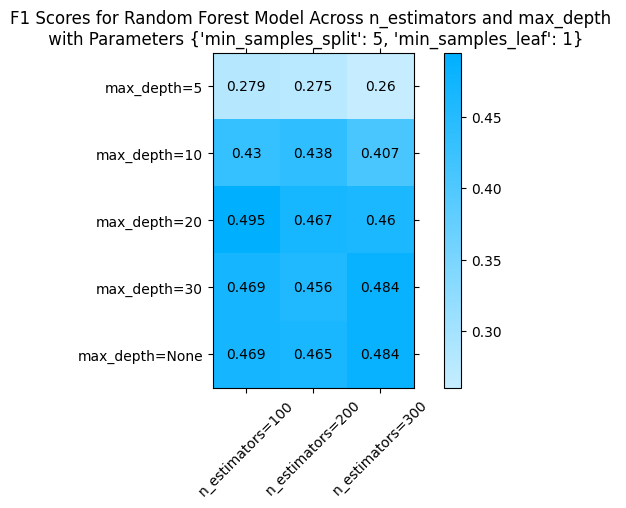

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_rati

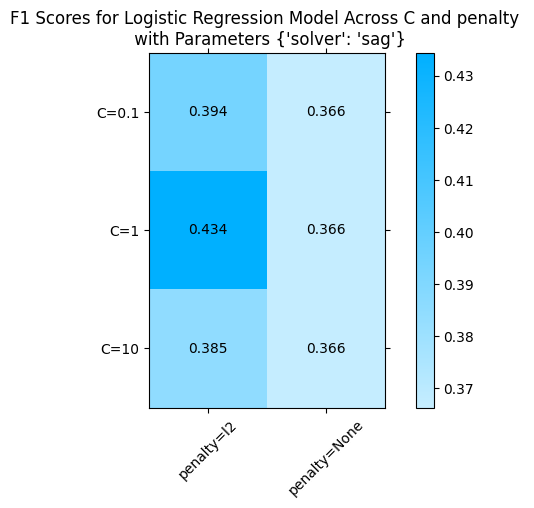

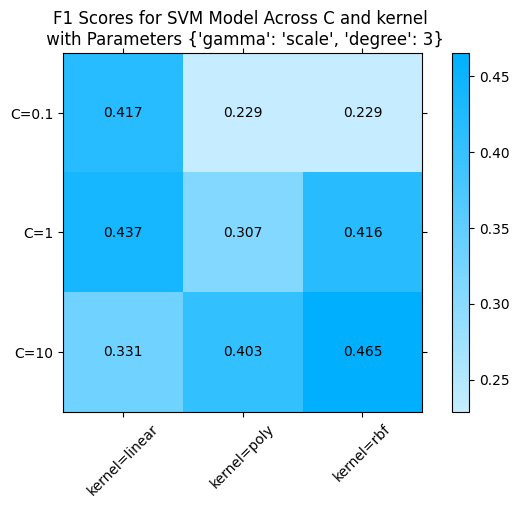

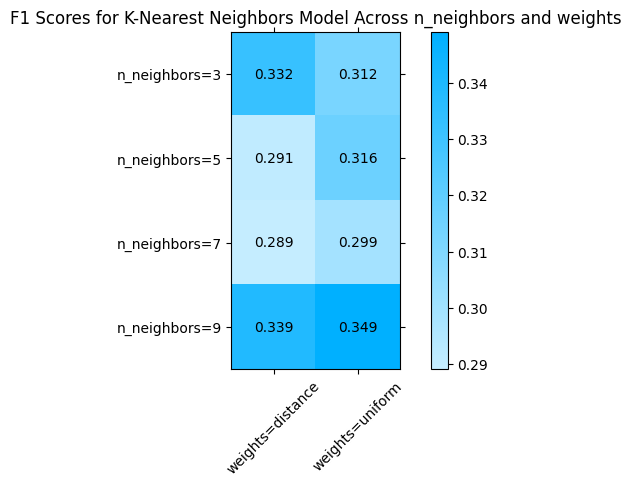

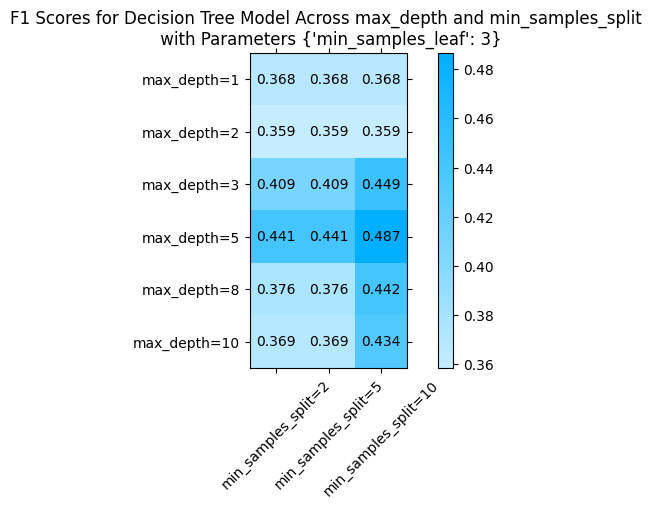

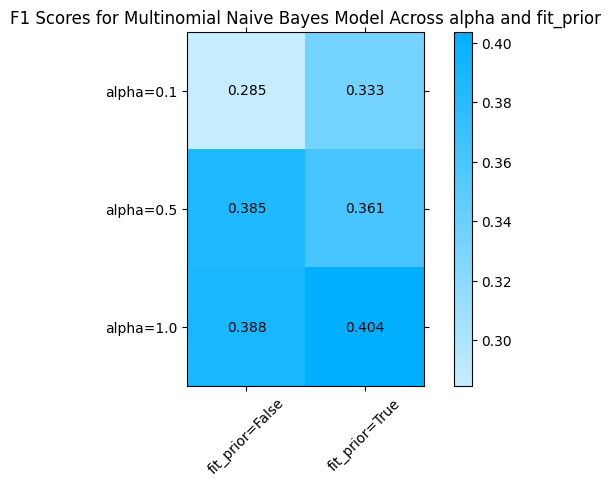

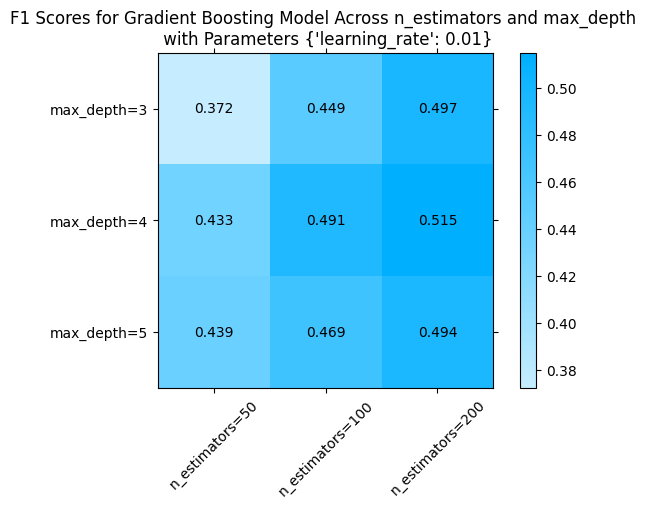

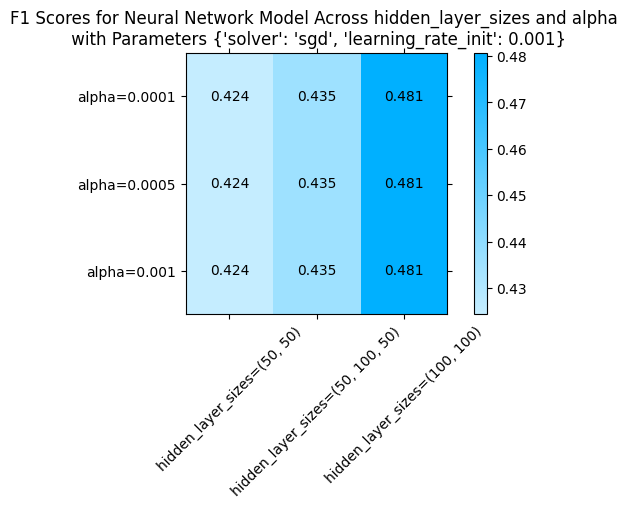

The best model is: Gradient Boosting


In [31]:
# Define the range of hyperparameters for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', None],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'], 
    'degree': [3, 4, 5] 
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

param_grid_dt = {
    'max_depth': [1, 2, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5, 8]
}

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid_nn = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
    'alpha': [0.0001, 0.0005, 0.001],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# Initialize models
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=10000), param_grid_lr),
    'SVM': (SVC(random_state=42), param_grid_svm),
    'K-Nearest Neighbors': (KNeighborsClassifier(), param_grid_knn),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), param_grid_dt),
    'Multinomial Naive Bayes': (MultinomialNB(), param_grid_nb),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), param_grid_gb),
    'Neural Network': (MLPClassifier(random_state=42, max_iter=10000), param_grid_nn)
}

best_models = {}
best_scores = {}

for model_name, (model, param_grid) in models.items():
    # Perform grid search with 5-fold cross-validation using F1 score as the scoring metric
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')

    # Fit the model to find the best hyperparameters
    grid_search.fit(labelled_bow, labels)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    keys = list(param_grid.keys())
    values = list(param_grid.values())
    param1 = keys[0]
    param2 = keys[1]

    # Iterate over key/value pairs after second pair
    subset = {}
    for key in keys[2:]:
        subset[key] = best_params[key]

    # Plot over first two hyperparameters
    plot.grid_search(grid_search.cv_results_, change=(param1, param2), subset=subset)
    if len(subset) > 0:
        plt.title(f"F1 Scores for {model_name} Model Across {param1} and {param2} \n with Parameters {subset}")
    else:
        plt.title(f"F1 Scores for {model_name} Model Across {param1} and {param2}")
    plt.show()

    # Keep track of best score for each model
    best_scores[model_name] = grid_search.best_score_

# Select the best model based on the mean cross-validation F1 score
best_model_name = max(best_models, key=lambda x: np.mean(cross_val_score(best_models[x], labelled_bow, labels, cv=5, scoring='f1_weighted')))
best_model = best_models[best_model_name]

print(f"The best model is: {best_model_name}")

### Visualising results

In [32]:
best_models

{'Random Forest': RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=42),
 'Logistic Regression': LogisticRegression(C=1, max_iter=10000, random_state=42, solver='sag'),
 'SVM': SVC(C=10, random_state=42),
 'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=9),
 'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=10,
                        random_state=42),
 'Multinomial Naive Bayes': MultinomialNB(),
 'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=200,
                            random_state=42),
 'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42,
               solver='sgd')}

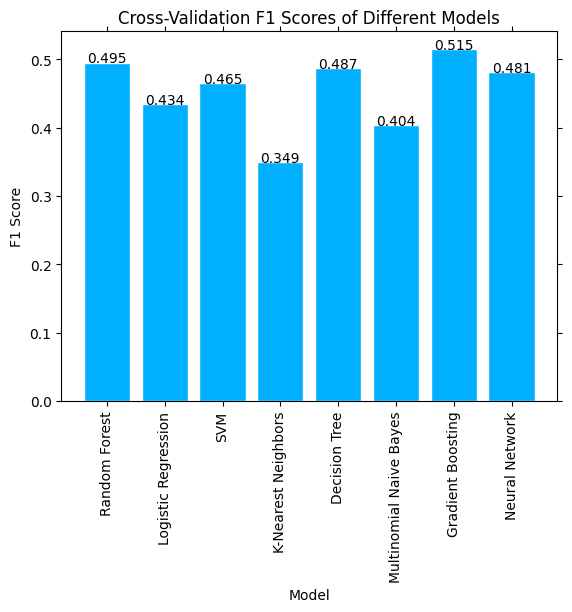

In [43]:
# Extracting model names and scores
model_names = list(best_scores.keys())
scores = list(best_scores.values())

# Creating a bar plot
plt.bar(model_names, scores)
plt.xticks(rotation=90)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Cross-Validation F1 Scores of Different Models')

# Label bars with values
for i in range(len(model_names)):
    plt.text(i, round(scores[i], 3), round(scores[i], 3), ha = 'center')

# Display the plot
plt.show()

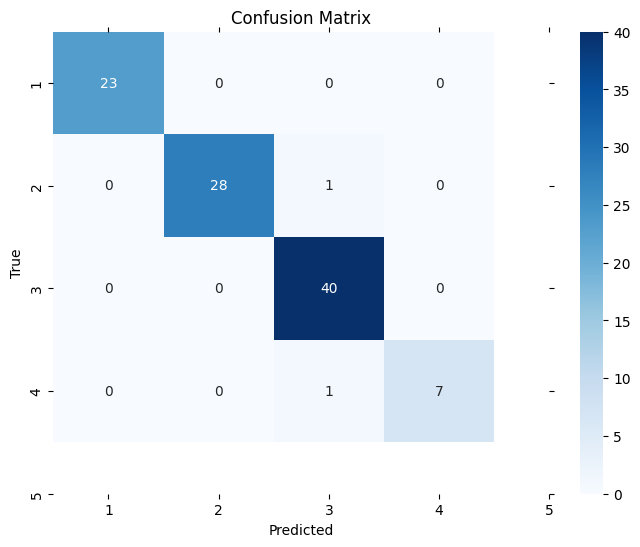

In [33]:
# Make predictions on the entire dataset
y_pred = best_model.predict(labelled_bow)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, y_pred)

# Define class names
class_names = [1, 2, 3, 4, 5]

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Calculate accuracy
accuracy = accuracy_score(labels, y_pred)

# Calculate F1 score (micro, weighted, or other averaging methods)
f1_micro = f1_score(labels, y_pred, average='micro')
f1_weighted = f1_score(labels, y_pred, average='weighted')

# Calculate precision (micro, weighted, or other averaging methods)
precision_micro = precision_score(labels, y_pred, average='micro')
precision_weighted = precision_score(labels, y_pred, average='weighted')

# Calculate recall (micro, weighted, or other averaging methods)
recall_micro = recall_score(labels, y_pred, average='micro')
recall_weighted = recall_score(labels, y_pred, average='weighted')

# Print the calculated metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Weighted): {f1_weighted}")
print(f"Precision (Micro): {precision_micro}")
print(f"Precision (Weighted): {precision_weighted}")
print(f"Recall (Micro): {recall_micro}")
print(f"Recall (Weighted): {recall_weighted}")


Accuracy: 0.98
F1 Score (Micro): 0.98
F1 Score (Weighted): 0.9798228498074454
Precision (Micro): 0.98
Precision (Weighted): 0.980952380952381
Recall (Micro): 0.98
Recall (Weighted): 0.98


In [35]:
# Predict labels for unlabelled data using the best model
predicted_scores = best_model.predict(unlabelled_bow)

In [36]:
papers_unlabelled[:3], predicted_scores[:3]

(['The psychological impact of quarantine and how to reduce it: rapid review of the evidence',
  'Global, regional, and national incidence, prevalence, and years lived with disability for 354 diseases and injuries for 195 countries and territories, 1990–2017: a systematic analysis for the Global Burden of Disease Study 2017',
  'A novel coronavirus outbreak of global health concern'],
 array([3, 2, 1]))